In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime

# 1. 감성 요약 CSV 로딩
def load_sentiment_summary(filepath):
    df = pd.read_csv(filepath)
    df['날짜'] = pd.to_datetime(df['날짜'])
    return df

# 2. 주가 수익률 계산 함수
def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=False):
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    df.reset_index(inplace=True)
    df = df[['날짜', '종가', 'Return']]
    if save_csv:
        df.to_csv(f"{ticker}_return.csv", index=False)
        print(f"[✓] Saved to {ticker}_return.csv")
    return df

# 3. 날짜 기준으로 감성 + 수익률 병합
def merge_sentiment_price(sentiment_df, return_df):
    return pd.merge(return_df, sentiment_df, on='날짜', how='inner')

# 4. 시차별 상관관계 분석
def lagged_correlation_analysis(df, ratio_col='평균감성점수', return_col='Return', min_lag=-3, max_lag=7):
    lag_results = []

    for lag in range(min_lag, max_lag + 1):
        df_lag = df.copy()
        df_lag[f'{return_col}_lag_{lag}'] = df_lag[return_col].shift(-lag)

        temp = df_lag.dropna(subset=[ratio_col, f'{return_col}_lag_{lag}'])
        corr = temp[ratio_col].corr(temp[f'{return_col}_lag_{lag}'])
        lag_results.append({'Lag': lag, 'Correlation': corr})

    lag_corr_df = pd.DataFrame(lag_results)
    best_row = lag_corr_df.loc[lag_corr_df['Correlation'].abs().idxmax()]

    # 출력
    print("✅ 시차별 상관관계:\n", lag_corr_df)
    print(f"\n🎯 가장 높은 상관: lag {best_row['Lag']}일, 상관계수 = {best_row['Correlation']:.4f}")

    # 시각화
    plt.figure(figsize=(10,6))
    plt.plot(lag_corr_df['Lag'], lag_corr_df['Correlation'], marker='o')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'{ratio_col}' vs '{return_col}' 절대값 상관관계 (lag {min_lag} ~ {max_lag})")
    plt.xlabel("시차 (일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_corr_df, best_row



✅ 시차별 상관관계:
     Lag  Correlation
0    -3     0.436623
1    -2    -0.443306
2    -1     0.029775
3     0    -0.095661
4     1     0.525591
5     2    -0.186285
6     3     0.045176
7     4    -0.137048
8     5     0.417420
9     6    -0.740393
10    7    -0.375617

🎯 가장 높은 상관: lag 6.0일, 상관계수 = -0.7404


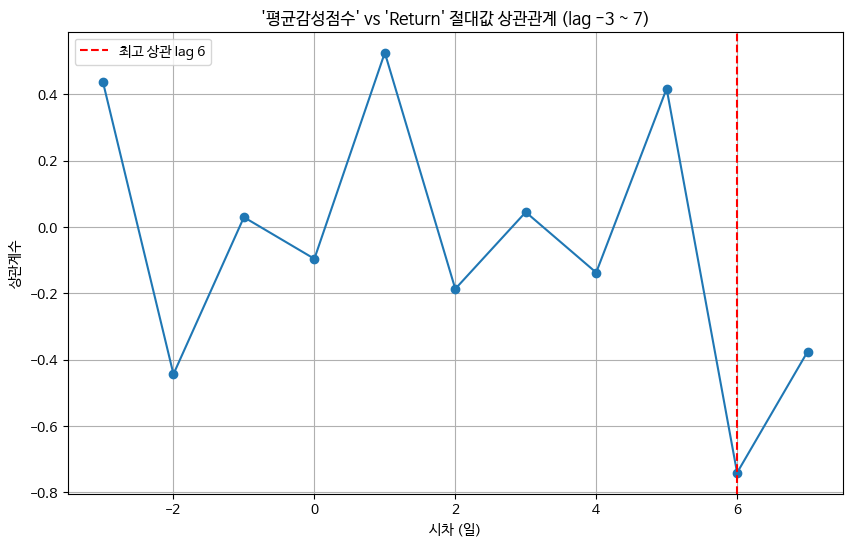

(    Lag  Correlation
 0    -3     0.436623
 1    -2    -0.443306
 2    -1     0.029775
 3     0    -0.095661
 4     1     0.525591
 5     2    -0.186285
 6     3     0.045176
 7     4    -0.137048
 8     5     0.417420
 9     6    -0.740393
 10    7    -0.375617,
 Lag            6.000000
 Correlation   -0.740393
 Name: 9, dtype: float64)

In [6]:
# 1. 감성 요약 데이터 불러오기
sentiment_df = load_sentiment_summary('daily_sentiment_summary.csv')

# 2. 주가 수익률 데이터 생성
price_df = get_daily_returns("042940", start_date="2024-06-21")

# 3. 병합
df_merged = merge_sentiment_price(sentiment_df, price_df)

# 4. 상관 분석 실행
lagged_correlation_analysis(
    df_merged,
    ratio_col='평균감성점수',   # 또는 weighted_score, ratio 등
    return_col='Return',
    min_lag=-3,
    max_lag=7
)